# Defining the Fitness and Criticality function

_Remark: Run the following command in case you have not run previous notebooks. We need to switch to the OpenSBST folder so that following code snippets can be executed._

In [17]:
cd opensbt-core

[Errno 2] No such file or directory: 'opensbt-core'
/home/sorokin/Projects/testing/search-based-test-case-generation/doc/jupyter/opensbt-core


## Fitness Function


In this tutorial we show how to specify two fitness functions for the AEB case study: 

- F1) This function evaluates the distance between the ego vehicle and the pedestrian.
- F2) This function outputs the velocity of the ego vehicle at the time of the minimal distance to the pedestrian.

By minimizing F1) and maximizing F2) we want to identify failure-revealing test cases. 

OpenSBT provdes the interface `Fitness` to implement fitness functions. `Fitness` provides the `eval` function which needs to be implemented with concrete evaluation instructions. The `eval`function receives as input an instance of  [`SimulationOutput`](https://git.fortiss.org/opensbt/opensbt-core/-/blob/main/simulation/simulator.py#L40-62) and returns a scalar or a vector valued output. 

A scalar value is returned when a single objective is to be optimized, otherwise a vector valued output is returned, such as in our example. Further `Fitness` contains the `min_max` function which has to return a tuple of `min` or `max` strings indicating whether the corresponding objective function is minimized or maximized. 
In the `name` function we provide names for both fitness functions to be shown in output artefacts.

The implementation of the examplary fitness function in OpenSBT then looks as follows:

In [7]:
from typing import Tuple
from evaluation.fitness import Fitness
from simulation.simulator import SimulationOutput
from utils import geometric
import numpy as np

class MyFitnessFunction(Fitness):
    @property
    def min_or_max(self):
        return "min", "max"

    @property
    def name(self):
        return "Min distance", "Velocity at min distance"

    def eval(self, simout: SimulationOutput) -> Tuple[float]:
        traceEgo = simout.location["ego"]                     # The actor names have to match the names written into the simulationoutput instance by the simulation adapter
        tracePed = simout.location["adversary"]              

        ind_min_dist = np.argmin(geometric.distPair(traceEgo, tracePed))

        # distance between ego and other object
        distance = np.min(geometric.distPair(traceEgo, tracePed))

        # speed of ego at time of the minimal distance
        speed = simout.speed["ego"][ind_min_dist]

        return (distance, speed)


## Criticality Function

Beside a fitness function, often a safety requirement/testing oracle is given specifying which test inputs are failure-revealing or not. In our example, such a safety requirement is: 

_<p style="text-align: center;">A test case is critical, when F1 is below .5m and ego vehicles velocity is not 0m/s._
    </p>
In OpenSBT, a safety requirements is represented by the interface class [Critical](evaluation/critical.py). `Critical` offers the method `eval`, where specific constraints can be implemented. It receives as input the fitness vector in form of an array, and the simulation output for the corresponding test input.

In [8]:
from evaluation.critical import Critical
from simulation.simulator import SimulationOutput

class MyCriticalFunction(Critical):
    def eval(self, vector_fitness, simout: SimulationOutput = None):
        # Corresponds F1 < 0.5 and F2 > 0 (inverted because minimization is performed)
        if (vector_fitness[0] < 0.5) and (vector_fitness[1] < 0):
            return True
        else:
            return False

## Testing

We can now run an experiment with newly created fitness and criticality function.

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      5 |             - |             -
     2 |       40 |      2 |  0.0137818633 |         ideal
     3 |       60 |      2 |  0.7451254011 |         nadir
     4 |       80 |      3 |  0.0319532935 |         ideal
     5 |      100 |      6 |  0.0399005199 |         ideal
     6 |      120 |      5 |  0.0166986504 |         ideal
     7 |      140 |      7 |  0.0057622738 |             f
     8 |      160 |      7 |  1.8416294276 |         nadir
     9 |      180 |      9 |  0.3890952111 |         nadir
    10 |      200 |      6 |  0.0236828648 |         ideal


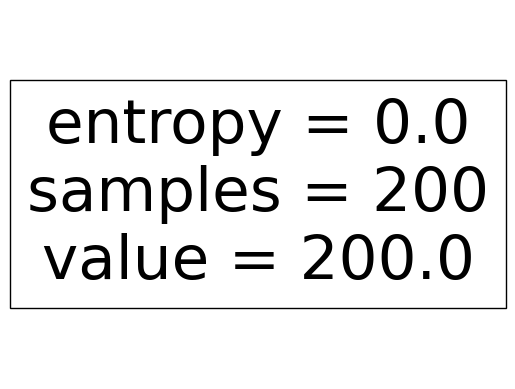

In [15]:
import pymoo

from model_ga.individual import IndividualSimulated
pymoo.core.individual.Individual = IndividualSimulated

from model_ga.population import PopulationExtended
pymoo.core.population.Population = PopulationExtended

from model_ga.result  import SimulationResult
pymoo.core.result.Result = SimulationResult

from model_ga.problem import SimulationProblem
pymoo.core.problem.Problem = SimulationProblem

from algorithm.nsga2_optimizer import NsgaIIOptimizer
from experiment.search_configuration import DefaultSearchConfiguration

import os
from evaluation.fitness import *
from problem.adas_problem import ADASProblem
from problem.pymoo_test_problem import PymooTestProblem
from experiment.experiment_store import *
from algorithm.algorithm import *
from evaluation.critical import *
from simulation.dummy_simulation import DummySimulator


problem = ADASProblem(
                      problem_name="DummySimulatorProblem",
                      scenario_path="scenarios/dummy_scenario.xosc",
                      xl=[0, 1, 0, 1],
                      xu=[360, 3,360, 3],
                      simulation_variables=[
                          "orientation_ego",
                          "velocity_ego",
                          "orientation_ped",
                          "velocity_ped"],
                      fitness_function=MyFitnessFunction(),
                      critical_function=MyCriticalFunction(),
                      simulate_function=DummySimulator.simulate,
                      simulation_time=10,
                      sampling_time=0.25
                      )

# Configure search algorithm
config=DefaultSearchConfiguration()
config.population_size = 20
config.n_generations = 10

optimizer = NsgaIIOptimizer(
                            problem=problem,
                            config=config)
# Run search
res = optimizer.run()

# Write results
res.write_results(params = optimizer.parameters)

We can inspect the results:

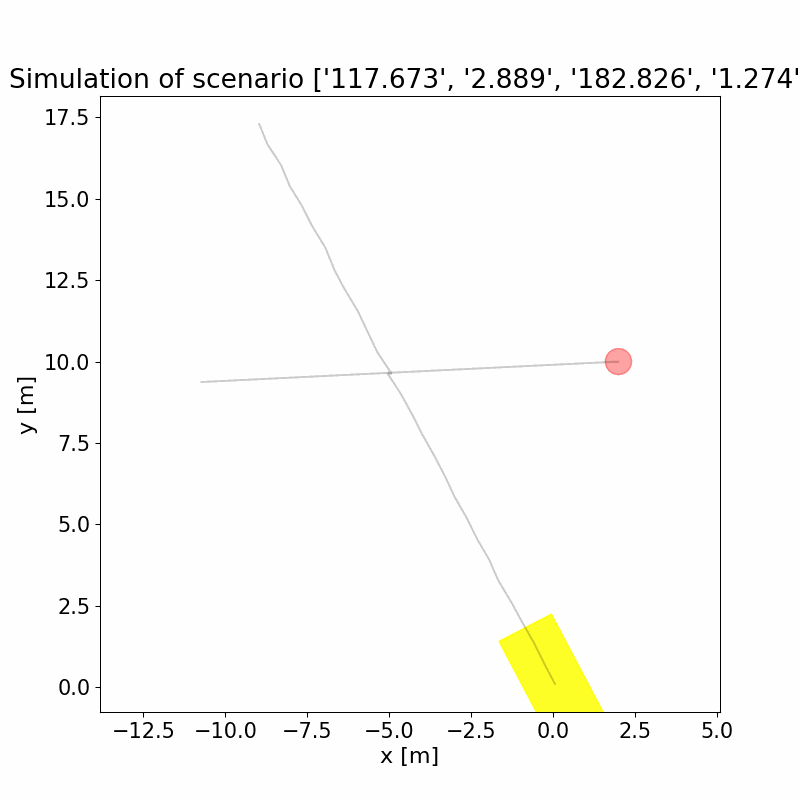

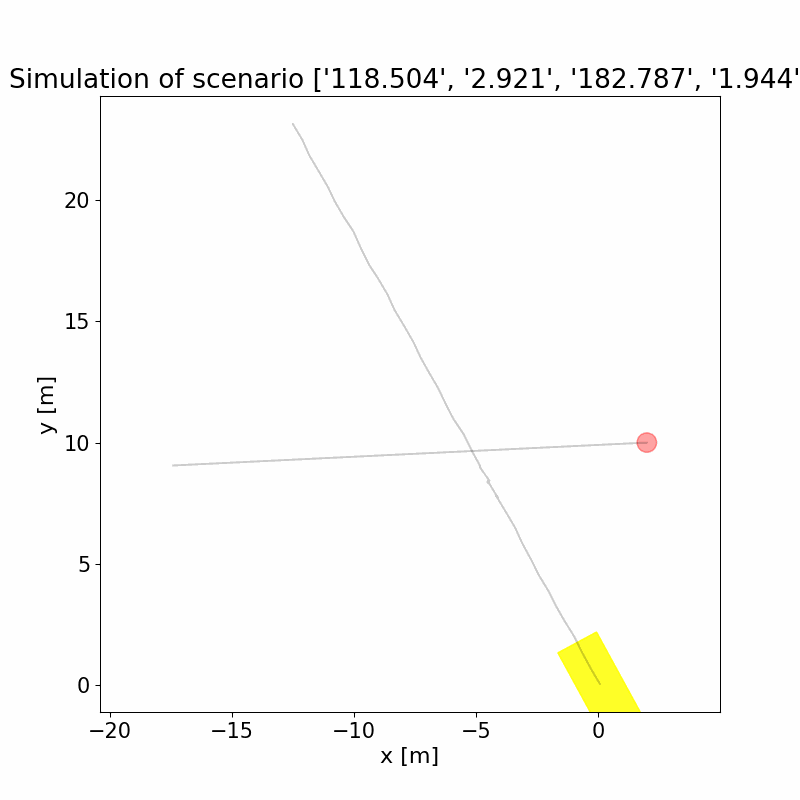

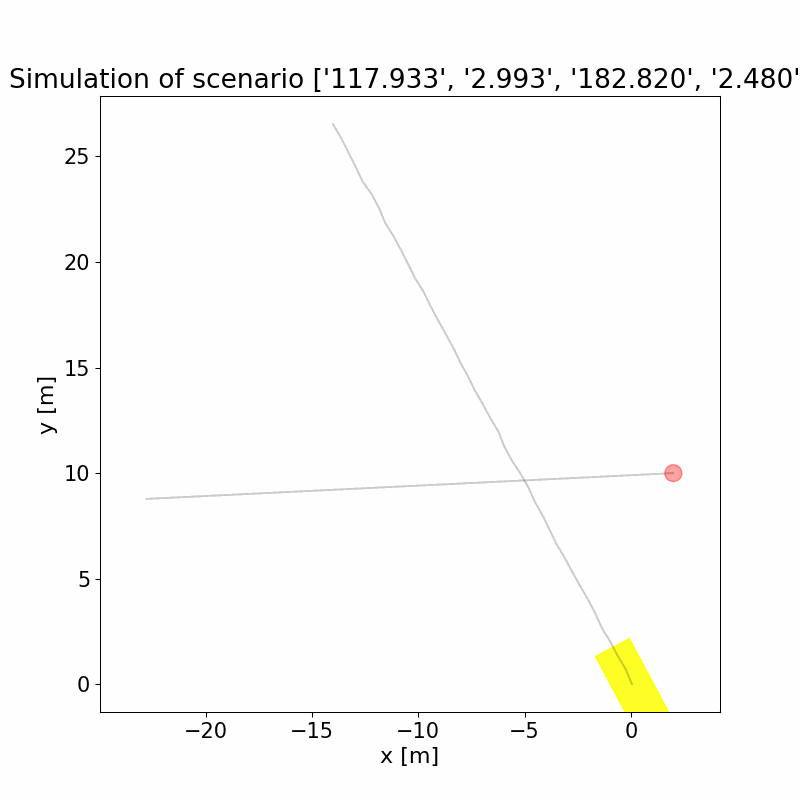

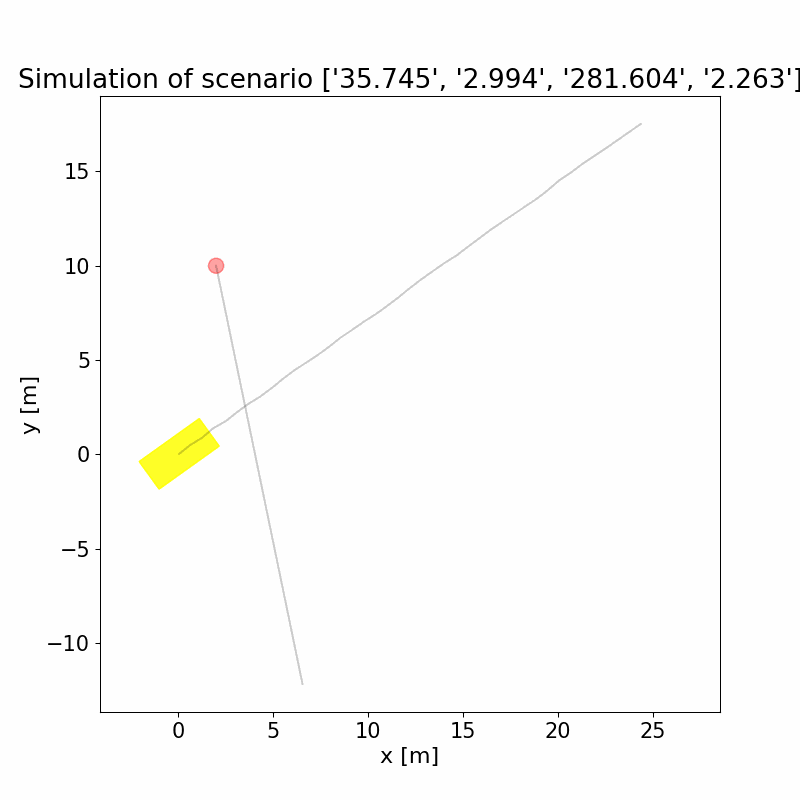

In [16]:
import pandas as pd
import os
exp_folders = os.listdir(os.getcwd() + "/results/DummySimulatorProblem/NSGA2/")
results_path = os.getcwd() + f"/results/DummySimulatorProblem/NSGA2/{exp_folders[0]}"

from IPython.display import Image
import os
n = 4 # show max n images
folder_gifs = results_path + os.sep + "gif"
i = 0
for f in os.listdir(folder_gifs):
    fpath = folder_gifs + os.sep + f
    if os.path.isfile(fpath) and i < n:
      img = Image(open(fpath,'rb').read(), width=300, height=300)
      display(img)
      i = i+1